<a href="https://colab.research.google.com/github/ParissaAmin/Renewable_Energy/blob/main/UCP/UCP_Optimization_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyomo
!apt-get install -y -qq glpk-utils


Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 123634 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_5.0-1_amd64.deb ...
Unpacking glpk-utils (5.0-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4b

# Code for UCP Implementation



#Model Setup

Model Creation:

ConcreteModel() is used to create an instance of the optimization model.
Sets:

RangeSet(num_generators) defines a set of 5 generators, numbered 1 through 5.

RangeSet(num_hours) defines a set of 24 hours for the scheduling period.

In [ ]:
from pyomo.environ import *

# Create the model
model = ConcreteModel()

# Define sets
num_generators = 5  # Number of generators
num_hours = 24  # Number of hours in the time horizon

model.Generators = RangeSet(num_generators)
model.Time = RangeSet(num_hours)

#Parameter Definitions


Generator Parameters:

Each generator has fixed minimum and maximum power outputs.

Costs for starting up, shutting down, and operating are defined for each generator.

Demand Profile:
Simulates hourly demand with periodic variations (increasing every 5 hours).
Reserve Factor:
Specifies that 10% of the demand is held as reserve capacity.


In [ ]:
# Define synthetic parameters for generators
min_output = {i: 20 for i in model.Generators}  # Minimum power output (MW)
max_output = {i: 100 for i in model.Generators}  # Maximum power output (MW)
startup_cost = {i: 200 for i in model.Generators}  # Startup cost ($)
shutdown_cost = {i: 100 for i in model.Generators}  # Shutdown cost ($)
operating_cost = {i: 10 for i in model.Generators}  # Operating cost per MW ($)

In [ ]:
# Define synthetic demand data (MW) for 24 hours
demand = {
    t: 100 + 10 * (t % 5) for t in model.Time
}  # Example demand profile with periodic variation

# Reserve requirement (10% of demand)
reserve_factor = 0.1

#Variables

Explanation:

Power Output:
model.P: Continuous variable for the power generated by each generator in each hour.
Binary Status Variables:
model.u: Indicates whether a generator is ON (1) or OFF (0).
model.v: Startup status (1 if started up in the current hour, otherwise 0).
model.w: Shutdown status (1 if shut down in the current hour, otherwise 0).

In [ ]:
# Define variables
model.P = Var(model.Generators, model.Time, within=NonNegativeReals)  # Power output
model.u = Var(model.Generators, model.Time, within=Binary)  # On/off status
model.v = Var(model.Generators, model.Time, within=Binary)  # Startup
model.w = Var(model.Generators, model.Time, within=Binary)  # Shutdown

# Objective function

Minimizes the total cost:
Operational Cost:
𝑃 𝑖,𝑡 × Operating Cost

Startup Cost:
𝑣𝑖,𝑡 × Startup Cost

Shutdown Cost:
𝑤 𝑖,𝑡 × Shutdown Cost

In [ ]:
#Minimize total cost
def total_cost(model):
    op_cost = sum(
        model.P[i, t] * operating_cost[i] for i in model.Generators for t in model.Time
    )
    start_cost = sum(
        model.v[i, t] * startup_cost[i] for i in model.Generators for t in model.Time
    )
    shut_cost = sum(
        model.w[i, t] * shutdown_cost[i] for i in model.Generators for t in model.Time
    )
    return op_cost + start_cost + shut_cost


model.Objective = Objective(rule=total_cost, sense=minimize)

# Constraints


1.  Power Balance Constraint
2.  Generator Limits
3. Reserve Requirement
4. Startup/Shutdown Constraints



In [ ]:

# Demand profile (MW) over 24 hours
demand = {t: 100 + 10 * (t % 5) for t in model.Time}  # Periodic variation

# 1. Power balance constraint
def demand_constraint(model, t):
    return sum(model.P[i, t] for i in model.Generators) >= demand[t]

model.DemandConstraint = Constraint(model.Time, rule=demand_constraint)



This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


In [ ]:
# 2. Generator limits using Big-M approach
def generator_min_limit(model, i, t):
    return model.P[i, t] >= model.u[i, t] * min_output[i]

def generator_max_limit(model, i, t):
    return model.P[i, t] <= model.u[i, t] * max_output[i]

model.GeneratorMinLimit = Constraint(model.Generators, model.Time, rule=generator_min_limit)
model.GeneratorMaxLimit = Constraint(model.Generators, model.Time, rule=generator_max_limit)



In [ ]:
# Reserve factor (percentage of demand to keep as reserve)
reserve_factor = 0.1  # 10% reserve requirement

# 3. Reserve requirement
def reserve_constraint(model, t):
    return sum(model.P[i, t] for i in model.Generators) >= demand[t] * (1 + reserve_factor)

model.ReserveConstraint = Constraint(model.Time, rule=reserve_constraint)


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


In [ ]:
# 4. Startup/shutdown constraints
def startup_shutdown_rule(model, i, t):
    if t == 1:
        return Constraint.Skip  # Skip for the first time step
    return model.u[i, t] - model.u[i, t - 1] == model.v[i, t] - model.w[i, t]


model.StartupShutdown = Constraint(model.Generators, model.Time, rule=startup_shutdown_rule)

In [ ]:
!apt-get install -y -qq glpk-utils



Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 123634 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_5.0-1_amd64.deb ...
Unpacking glpk-utils (5.0-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4b

In [ ]:
!glpsol --version


GLPSOL--GLPK LP/MIP Solver 5.0
Copyright (C) 2000-2020 Free Software Foundation, Inc.

This program has ABSOLUTELY NO WARRANTY.

This program is free software; you may re-distribute it under the terms
of the GNU General Public License version 3 or later.


# Solve the Model

In [ ]:
solver = SolverFactory("glpk", executable="/usr/bin/glpsol")
results = solver.solve(model)


# Display Results

In [ ]:
# Display total cost
print("Total Cost: $", model.Objective())

# Display generator schedules
for t in model.Time:
    print(f"\nHour {t}:")
    for i in model.Generators:
        print(
            f"  Generator {i}: Power = {model.P[i, t].value:.2f} MW, Status = {int(model.u[i, t].value)}"
        )



Total Cost: $ 31900.0

Hour 1:
  Generator 1: Power = 100.00 MW, Status = 1
  Generator 2: Power = 21.00 MW, Status = 1
  Generator 3: Power = 0.00 MW, Status = 0
  Generator 4: Power = 0.00 MW, Status = 0
  Generator 5: Power = 0.00 MW, Status = 0

Hour 2:
  Generator 1: Power = 100.00 MW, Status = 1
  Generator 2: Power = 32.00 MW, Status = 1
  Generator 3: Power = 0.00 MW, Status = 0
  Generator 4: Power = 0.00 MW, Status = 0
  Generator 5: Power = 0.00 MW, Status = 0

Hour 3:
  Generator 1: Power = 100.00 MW, Status = 1
  Generator 2: Power = 43.00 MW, Status = 1
  Generator 3: Power = 0.00 MW, Status = 0
  Generator 4: Power = 0.00 MW, Status = 0
  Generator 5: Power = 0.00 MW, Status = 0

Hour 4:
  Generator 1: Power = 54.00 MW, Status = 1
  Generator 2: Power = 100.00 MW, Status = 1
  Generator 3: Power = 0.00 MW, Status = 0
  Generator 4: Power = 0.00 MW, Status = 0
  Generator 5: Power = 0.00 MW, Status = 0

Hour 5:
  Generator 1: Power = 90.00 MW, Status = 1
  Generator 2: Po

# Visualization

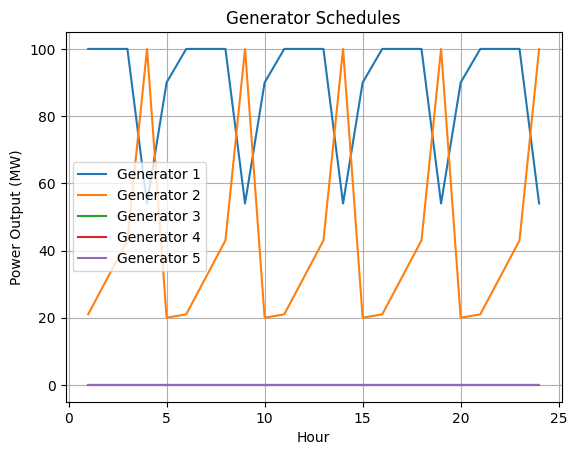

In [ ]:
import matplotlib.pyplot as plt

schedules = {i: [model.P[i, t].value for t in model.Time] for i in model.Generators}

for i in model.Generators:
    plt.plot(range(1, num_hours + 1), schedules[i], label=f"Generator {i}")

plt.xlabel("Hour")
plt.ylabel("Power Output (MW)")
plt.title("Generator Schedules")
plt.legend()
plt.grid()
plt.show()



#Solve the Model

is the phase where you run the optimization model to compute the optimal solution based on the input data, constraints, and objective function defined in earlier steps. This involves:

Choosing an optimization solver.
Solving the model.
Extracting and displaying the results.
Detailed Steps to Solve the Model
1. Choose a Solver
Solvers are mathematical engines that process the optimization model and compute solutions.
In this example, we use GLPK, a free and open-source solver.
Other solvers like CBC, Gurobi, or CPLEX can also be used.

#Dataset: National Renewable Energy Laboratory (NREL) - Wind and Solar Resource Data
Renewable Energy Generation
Description: Includes detailed wind and solar generation data at different locations.
Application: Introduce wind and solar generators into your model with varying output based on weather data.

In [ ]:
import requests
import pandas as pd

# Replace with your NREL API Key
api_key = "fvj2ei4nfWzO5LIJ23ePgh998sy2Ce6f3IrU9bfS"

# Define API Endpoint and Parameters
url = "https://developer.nrel.gov/api/solar/nsrdb_psm3_download.csv"

# Use a sample location if no specific location is known
params = {
    "wkt": "POINT(-104.9903 39.7392)",  # Denver, CO coordinates (replace as needed)
    "names": "2020",  # Year of data
    "interval": "60",  # Data interval (60 minutes)
    "api_key": api_key,
    "attributes": "ghi,dni,wind_speed",  # Specify attributes: GHI, DNI, wind speed, etc.
    "utc": "true",  # Use UTC time
    "email": "amin.parissa@gmail.com",  # Replace with your registered email
}

# Fetch Data
response = requests.get(url, params=params)

if response.status_code == 200:
    # Save the data to a CSV file
    with open("nrel_data.csv", "w") as file:
        file.write(response.text)
    print("Data downloaded successfully!")

    # Load the CSV into a Pandas DataFrame
    df = pd.read_csv("nrel_data.csv")
    print(df.head())
else:
    print("Error:", response.status_code, response.text)


Data downloaded successfully!
  Source Location ID City State Country Latitude Longitude   Time Zone  \
0  NSRDB      484137    -     -       -    39.73   -104.98           0   
1   Year       Month  Day  Hour  Minute      GHI       DNI  Wind Speed   
2   2020           1    1     0      30        0         0         2.6   
3   2020           1    1     1      30        0         0         3.6   
4   2020           1    1     2      30        0         0         4.4   

   Elevation  Local Time Zone  ... Cloud Type 11 Cloud Type 12 Fill Flag 0  \
0     1604.0             -7.0  ...          Dust         Smoke         NaN   
1        NaN              NaN  ...           NaN           NaN         NaN   
2        NaN              NaN  ...           NaN           NaN         NaN   
3        NaN              NaN  ...           NaN           NaN         NaN   
4        NaN              NaN  ...           NaN           NaN         NaN   

     Fill Flag 1     Fill Flag 2       Fill Flag 3      

#Clean and Process the Data
The raw data may have unnecessary columns and missing values. We'll clean it and keep only relevant attributes (e.g., GHI, DNI, Wind Speed).

In [ ]:
print(df.columns)  # Display the column names


Index(['Source', 'Location ID', 'City', 'State', 'Country', 'Latitude',
       'Longitude', 'Time Zone', 'Elevation', 'Local Time Zone',
       'Clearsky DHI Units', 'Clearsky DNI Units', 'Clearsky GHI Units',
       'Dew Point Units', 'DHI Units', 'DNI Units', 'GHI Units',
       'Solar Zenith Angle Units', 'Temperature Units', 'Pressure Units',
       'Relative Humidity Units', 'Precipitable Water Units',
       'Wind Direction Units', 'Wind Speed Units', 'Cloud Type -15',
       'Cloud Type 0', 'Cloud Type 1', 'Cloud Type 2', 'Cloud Type 3',
       'Cloud Type 4', 'Cloud Type 5', 'Cloud Type 6', 'Cloud Type 7',
       'Cloud Type 8', 'Cloud Type 9', 'Cloud Type 10', 'Cloud Type 11',
       'Cloud Type 12', 'Fill Flag 0', 'Fill Flag 1', 'Fill Flag 2',
       'Fill Flag 3', 'Fill Flag 4', 'Fill Flag 5', 'Surface Albedo Units',
       'Version'],
      dtype='object')


Select Relevant Columns
Based on your Unit Commitment Problem (UCP) model and machine learning integration goals, the following columns are relevant:

GHI Units: Global Horizontal Irradiance – useful for solar energy modeling.
DNI Units: Direct Normal Irradiance – another key input for solar power generation.
Wind Speed Units: Crucial for wind energy calculations.
Temperature Units: Can affect efficiency of solar panels and other equipment.
Relative Humidity Units: Impacts renewable energy performance and weather forecasting.

In [ ]:
print(df.columns)
print(f"Number of columns in dataset: {len(df.columns)}")



Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'GHI', 'DNI', 'Wind Speed'], dtype='object')
Number of columns in dataset: 8


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("nrel_data.csv", skiprows=2)  # Skip metadata rows if necessary

# Confirm column names and count
print("Columns in the dataset:", df.columns)
print(f"Number of columns: {len(df.columns)}")

# Rename columns for clarity (if needed)
df.columns = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'GHI', 'DNI', 'Wind Speed']

# Select relevant columns
relevant_columns = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'GHI', 'DNI', 'Wind Speed']
df = df[relevant_columns]

# Convert to numeric and handle missing values
df = df.apply(pd.to_numeric, errors='coerce').dropna()

# Preview the cleaned dataset
print("Cleaned Dataset Preview:")
print(df.head())

# Save the cleaned data for further analysis
df.to_csv("cleaned_nrel_data.csv", index=False)
print("Cleaned dataset saved to 'cleaned_nrel_data.csv'")


Columns in the dataset: Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'GHI', 'DNI', 'Wind Speed'], dtype='object')
Number of columns: 8
Cleaned Dataset Preview:
   Year  Month  Day  Hour  Minute  GHI  DNI  Wind Speed
0  2020      1    1     0      30    0    0         2.6
1  2020      1    1     1      30    0    0         3.6
2  2020      1    1     2      30    0    0         4.4
3  2020      1    1     3      30    0    0         5.2
4  2020      1    1     4      30    0    0         5.6
Cleaned dataset saved to 'cleaned_nrel_data.csv'


#  Integrating Data into UCP Model
Understand the Dataset:

GHI (Global Horizontal Irradiance): Represents solar power potential.
DNI (Direct Normal Irradiance): Useful for concentrated solar power.
Wind Speed: A key input for estimating wind power generation.
Prepare Data for UCP:

Aggregate the data to match the time granularity of your UCP model (e.g., hourly intervals).
Use this data to model renewable energy generation inputs for your optimization.
Data Aggregation: Since your UCP model works with hourly time intervals, aggregate the GHI, DNI, and Wind Speed data:

In [ ]:
# Aggregate data to hourly intervals
df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])
df_hourly = df.resample('H', on='Datetime').mean()

# Drop unnecessary columns after aggregation
df_hourly = df_hourly[['GHI', 'DNI', 'Wind Speed']]
print(df_hourly.head())

# Save aggregated data
df_hourly.to_csv("aggregated_nrel_data.csv")
print("Aggregated data saved to 'aggregated_nrel_data.csv'")


                     GHI  DNI  Wind Speed
Datetime                                 
2020-01-01 00:00:00  0.0  0.0         2.6
2020-01-01 01:00:00  0.0  0.0         3.6
2020-01-01 02:00:00  0.0  0.0         4.4
2020-01-01 03:00:00  0.0  0.0         5.2
2020-01-01 04:00:00  0.0  0.0         5.6
Aggregated data saved to 'aggregated_nrel_data.csv'


<ipython-input-14-976884e172b0>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H', on='Datetime').mean()


#Machine Learning Integration
Train a Machine Learning Model: Use the aggregated renewable energy data to forecast net demand by combining it with simulated or existing base demand data.

Incorporate ML Predictions into the UCP Model: Use the forecasted demand as the input to your Pyomo optimization model.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pyomo.environ import *

# Step 1: Load and preprocess data
# Load the aggregated renewable energy data
df_hourly = pd.read_csv("aggregated_nrel_data.csv", parse_dates=["Datetime"], index_col="Datetime")

# Simulate base demand (replace with actual demand if available)
base_demand = 100 + 20 * np.sin(2 * np.pi * df_hourly.index.hour / 24)

# Renewable energy generation efficiency
solar_efficiency = 0.2  # Example efficiency for solar
wind_efficiency = 0.3  # Example efficiency for wind

# Calculate renewable generation and net demand
df_hourly['Renewable_Generation'] = df_hourly['GHI'] * solar_efficiency + df_hourly['Wind Speed'] * wind_efficiency
df_hourly['Base_Demand'] = base_demand
df_hourly['Net_Demand'] = df_hourly['Base_Demand'] - df_hourly['Renewable_Generation']


In [ ]:
# Features and target for ML model
features = df_hourly[['GHI', 'Wind Speed']].copy()
features['Hour'] = df_hourly.index.hour
features['DayOfWeek'] = df_hourly.index.dayofweek
features['Month'] = df_hourly.index.month

target = df_hourly['Net_Demand']

In [ ]:
# Check for missing values in the target variable
print("Number of missing values in target:", target.isna().sum())

# Drop rows with missing Net_Demand
data_cleaned = df_hourly.dropna(subset=['Net_Demand'])
print("Data cleaned. Rows remaining:", len(data_cleaned))

# Update features and target
features = data_cleaned[['GHI', 'Wind Speed']].copy()
features['Hour'] = data_cleaned.index.hour
features['DayOfWeek'] = data_cleaned.index.dayofweek
features['Month'] = data_cleaned.index.month

target = data_cleaned['Net_Demand']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
predictions = rf_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")



Number of missing values in target: 24
Data cleaned. Rows remaining: 8760
Mean Squared Error: 0.26993398486302206


In [ ]:
# Step 3: Forecast Demand for the Next 24 Hours
# Use the latest data for forecasting
latest_features = features.iloc[-24:]
predicted_demand = rf_model.predict(latest_features)

#Integrating ML Predictions into the UCP Model

In [ ]:

# Define the UCP model
num_generators = 5
num_hours = 24

model = ConcreteModel()
model.Generators = RangeSet(num_generators)
model.Time = RangeSet(num_hours)

In [ ]:
# Generator parameters
min_output = {i: 20 for i in model.Generators}
max_output = {i: 100 for i in model.Generators}
startup_cost = {i: 200 for i in model.Generators}
shutdown_cost = {i: 100 for i in model.Generators}
operating_cost = {i: 10 for i in model.Generators}

# Variables
model.P = Var(model.Generators, model.Time, within=NonNegativeReals)
model.u = Var(model.Generators, model.Time, within=Binary)
model.v = Var(model.Generators, model.Time, within=Binary)
model.w = Var(model.Generators, model.Time, within=Binary)

In [ ]:
# Objective function
def total_cost(model):
    op_cost = sum(
        model.P[i, t] * operating_cost[i] for i in model.Generators for t in model.Time
    )
    start_cost = sum(
        model.v[i, t] * startup_cost[i] for i in model.Generators for t in model.Time
    )
    shut_cost = sum(
        model.w[i, t] * shutdown_cost[i] for i in model.Generators for t in model.Time
    )
    return op_cost + start_cost + shut_cost

model.Objective = Objective(rule=total_cost, sense=minimize)

#Constraints

In [ ]:

# Power balance constraint
predicted_demand_dict = {t: predicted_demand[t - 1] for t in model.Time}

def demand_constraint(model, t):
    return sum(model.P[i, t] for i in model.Generators) >= predicted_demand_dict[t]

model.DemandConstraint = Constraint(model.Time, rule=demand_constraint)

In [ ]:
# Generator limits
def generator_min_limit(model, i, t):
    return model.P[i, t] >= model.u[i, t] * min_output[i]

def generator_max_limit(model, i, t):
    return model.P[i, t] <= model.u[i, t] * max_output[i]

model.GeneratorMinLimit = Constraint(model.Generators, model.Time, rule=generator_min_limit)
model.GeneratorMaxLimit = Constraint(model.Generators, model.Time, rule=generator_max_limit)

In [ ]:
# Startup/shutdown constraints
def startup_shutdown_rule(model, i, t):
    if t == 1:
        return Constraint.Skip
    return model.u[i, t] - model.u[i, t - 1] == model.v[i, t] - model.w[i, t]

model.StartupShutdown = Constraint(model.Generators, model.Time, rule=startup_shutdown_rule)

NameError: name 'Constraint' is not defined

In [ ]:
!apt-get install -y glpk-utils


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libamd2 libcolamd2 libglpk40 libsuitesparseconfig5
Suggested packages:
  libiodbc2-dev
The following NEW packages will be installed:
  glpk-utils libamd2 libcolamd2 libglpk40 libsuitesparseconfig5
0 upgraded, 5 newly installed, 0 to remove and 49 not upgraded.
Need to get 625 kB of archives.
After this operation, 2,158 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsuitesparseconfig5 amd64 1:5.10.1+dfsg-4build1 [10.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libamd2 amd64 1:5.10.1+dfsg-4build1 [21.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libcolamd2 amd64 1:5.10.1+dfsg-4build1 [18.0 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libglpk40 amd64 5.0-1 [361 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 glpk-ut

In [ ]:
!glpsol --version


GLPSOL--GLPK LP/MIP Solver 5.0
Copyright (C) 2000-2020 Free Software Foundation, Inc.

This program has ABSOLUTELY NO WARRANTY.

This program is free software; you may re-distribute it under the terms
of the GNU General Public License version 3 or later.


In [ ]:
#find the path glpsol installed
!which glpsol


/usr/bin/glpsol


In [ ]:
# Solve the model
solver = SolverFactory("glpk", executable="/usr/bin/glpsol")  # Adjust the path if necessary
results = solver.solve(model)

# Display results
print("Total Cost:", model.Objective())
for t in model.Time:
    print(f"Hour {t}:")
    for i in model.Generators:
        print(
            f"  Generator {i}: Power = {model.P[i, t].value:.2f} MW, Status = {int(model.u[i, t].value)}"
        )


Total Cost: 19164.245668116844
Hour 1:
  Generator 1: Power = 79.58 MW, Status = 1
  Generator 2: Power = 0.00 MW, Status = 0
  Generator 3: Power = 0.00 MW, Status = 0
  Generator 4: Power = 0.00 MW, Status = 0
  Generator 5: Power = 20.00 MW, Status = 1
Hour 2:
  Generator 1: Power = 84.55 MW, Status = 1
  Generator 2: Power = 0.00 MW, Status = 0
  Generator 3: Power = 0.00 MW, Status = 0
  Generator 4: Power = 0.00 MW, Status = 0
  Generator 5: Power = 20.00 MW, Status = 1
Hour 3:
  Generator 1: Power = 20.00 MW, Status = 1
  Generator 2: Power = 0.00 MW, Status = 0
  Generator 3: Power = 0.00 MW, Status = 0
  Generator 4: Power = 0.00 MW, Status = 0
  Generator 5: Power = 89.21 MW, Status = 1
Hour 4:
  Generator 1: Power = 20.00 MW, Status = 1
  Generator 2: Power = 0.00 MW, Status = 0
  Generator 3: Power = 0.00 MW, Status = 0
  Generator 4: Power = 0.00 MW, Status = 0
  Generator 5: Power = 93.24 MW, Status = 1
Hour 5:
  Generator 1: Power = 20.00 MW, Status = 1
  Generator 2: Po

# Visualizing the Results
To better understand the schedule, you can visualize the generator outputs:

Plot Power Outputs per Generator

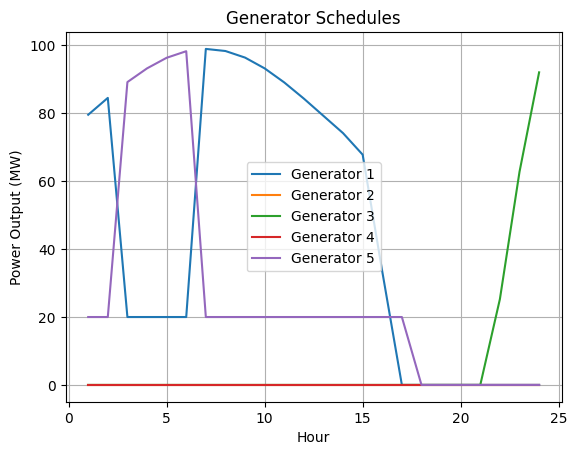

In [ ]:
import matplotlib.pyplot as plt

# Extract data for plotting
hours = list(model.Time)
power_outputs = {i: [model.P[i, t].value for t in model.Time] for i in model.Generators}

# Plot
for gen, output in power_outputs.items():
    plt.plot(hours, output, label=f"Generator {gen}")

plt.xlabel("Hour")
plt.ylabel("Power Output (MW)")
plt.title("Generator Schedules")
plt.legend()
plt.grid()
plt.show()


#Plot Generator Status

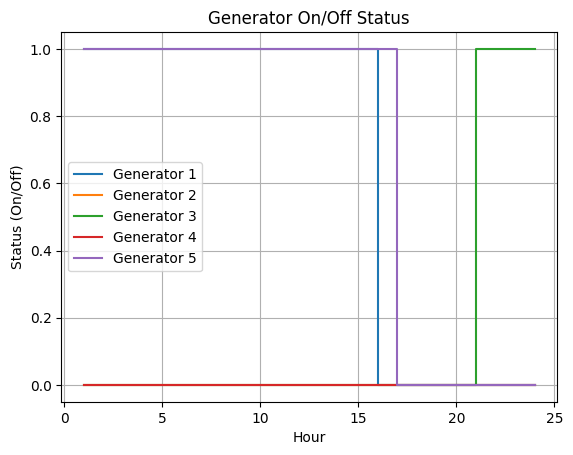

In [ ]:
# Extract status data
statuses = {i: [model.u[i, t].value for t in model.Time] for i in model.Generators}

# Plot
for gen, status in statuses.items():
    plt.step(hours, status, label=f"Generator {gen}")

plt.xlabel("Hour")
plt.ylabel("Status (On/Off)")
plt.title("Generator On/Off Status")
plt.legend()
plt.grid()
plt.show()
